# SLIC-ed imgs to training set

In [232]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.transform import resize
from matplotlib import image as mpimg
import os
from scipy.misc import imresize

In [12]:
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'
nfiles = len(os.listdir(path + pimg))
nfiles_maps = len(os.listdir(path + pgt))
print(nfiles, nfiles_maps)

8 10001


In [175]:
def load_image(infilename):
    """ Reads images """
    data = mpimg.imread(infilename)
    return data


def load_batch(path, pimg, pgt, nfiles, batch_size=1000):
    
    # sample randomly
    randomise = np.random.choice(nfiles, size=batch_size, replace=False)

    # generate file lists
    print('Reading file names ..')
    filelist = []
    filelist = [os.listdir(path + pimg)[i] for i in randomise]
    gtlist = ['gt_' + filelist[i] for i in range(len(filelist))]
    print('read')
    
    # initialise datasets
    imgs = []
    gts = []

    # read files
    print('Reading ', batch_size, ' files...')
    i = 0
    while i < batch_size:
        name = path + pimg + filelist[i]
        gtname = path + pgt + gtlist[i]
        if name.endswith(".jpg"):
            i += 1
            imgs.append(load_image(name))
            gts.append(load_image(gtname))
    
    imgs = np.asarray(imgs)
    gts = np.asarray(gts)
    print('Read ', i, ' files.')
    print('Check: img size', imgs.shape, '\tgt size', gts.shape)
    return [imgs, gts]

In [176]:
batch_size = 6
# get some data
[imgs, gts] = load_batch(path, pimg, pgt, nfiles, batch_size)

Reading file names ..
read
Reading  6  files...
Read  6  files.
Check: img size (6, 768, 768, 3) 	gt size (6, 768, 768)


In [64]:
# safekeeping - sometimes you do dumb things
imsave = np.copy(imgs)
gtsave = np.copy(gts)

In [185]:
# create SLIC megapixels
# I am lame and will do a loop
n_segments = 100
SLIC_list = np.asarray([slic(imgs[i,:], n_segments, compactness=20, sigma=10) for i in range(imgs.shape[0])])

In [66]:
# DEBUG
# check this worked out:
SLIC_list.shape
print(SLIC_list[1,:])

[[ 0  0  0 ...  8  8  8]
 [ 0  0  0 ...  8  8  8]
 [ 0  0  0 ...  8  8  8]
 ...
 [90 90 90 ... 96 96 96]
 [90 90 90 ... 96 96 96]
 [90 90 90 ... 96 96 96]]


In [67]:
# find smallest patch around each pixel - function
def box(seg, i):
    xind = np.nonzero(seg.ravel('C') == i)
    [xmax, temp] = np.unravel_index(np.max(xind), seg.shape, order = 'C')
    [xmin, temp] = np.unravel_index(np.min(xind), seg.shape, order = 'C')
    yind = np.nonzero(seg.ravel('F') == i)
    [temp, ymax] = np.unravel_index(np.max(yind), seg.shape, order = 'F')
    [temp, ymin] = np.unravel_index(np.min(yind), seg.shape, order = 'F')
    return np.array([xmax, ymax, xmin, ymin])

In [68]:
# initialise boxes
boxes = np.zeros((batch_size, n_segments, 4))
# run box function to find all superpixel patches sizes
for i in range(batch_size):
    for j in range(n_segments):
        # sometimes we get less than n_segment boxes
        try:
            boxes[i,j,:] = box(SLIC_list[i,:],j)
        except ValueError:
            boxes[i,j,:] = np.array([0,0,0,0])

In [58]:
# DEBUG
#
# check this worked out:
boxes.shape

(6, 100, 4)

In [60]:
SLIC_list[0].max()

99

## LABELS

Study case: image 'gt_0a20d8143.jpg'

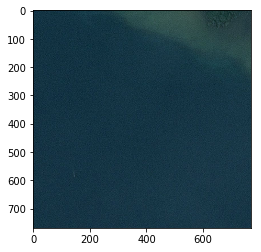

In [144]:
filename = '0a20d8143.jpg'
st = mpimg.imread(path + pimg + filename)
plt.imshow(st)
plt.show()

mask:

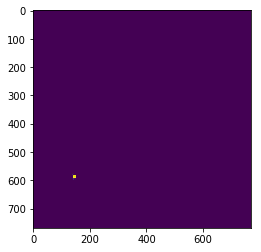

In [145]:
filename = 'gt_0a20d8143.jpg'
gt = mpimg.imread(path + pgt+filename)
plt.imshow(gt)
plt.show()

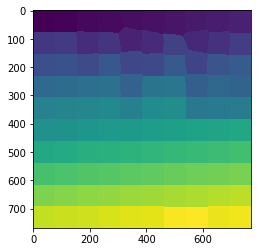

In [138]:
SLIC = slic(st, n_segments, compactness=20, sigma=10)
plt.imshow(SLIC)
plt.show()

In [139]:
# finding the patch that contain the boat
for i in range(99):
    print(i, np.sum(gt[SLIC == i] > 125))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 86
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0


In [146]:
#as you can see this value is too small and it will classify this patch as 0
num = np.sum(gt[SLIC == 71] > 125)
denom = gt[SLIC == 71].size
float(num)/float(denom)

0.014504975543936583

In [148]:
#that's why we need this term as well
thres2 = 0.5
size_true = np.sum(gt > 125)
print(num/size_true)
num/size_true > thres2

1.0


True

In [218]:
# create training set for gts
thres1 = 0.25
thres2 = 0.5
def patch_cat(gt, SLIC, i, thres1, thres2):
    num = np.sum(gt[SLIC == i] > 125)
    denom = gt[SLIC == i].size
    size_true = np.sum(gt > 125)
    if float(num)/float(denom)>thres1:
        return 1
    else:
        if float(size_true) > 0 and float(num)/float(size_true) > thres2:
            return 1
        else: return 0
    
# old version
def patch_cat_old(gt, SLIC, i, thres):
    num = np.sum(gt[SLIC == i] > 125)
    denom = gt[SLIC == i].size
    if float(num)/float(denom)>thres:
        return 1
    else:
        return 0

In [219]:
# OLD VERSION WITH NUMPY
#
# initialise y_train - setting y to -1 for noon-existing patches
y_train = np.zeros((10, 100))-1
# populate y_train using patch_cat
thres1 = 0.25
thres2 = 0.2
for j in range(batch_size):
    for i in range(np.max(SLIC_list[j,:])):
        y_train[j,i] = patch_cat(gts[j,:], SLIC_list[j,:], i, thres1, thres2)

In [220]:
# LIST VERSION more flexible
#
# populate y_train using patch_cat
thres1 = 0.2
thres2 = 0.2
y_train = np.empty((batch_size,0)).tolist()
for j in range(batch_size):
    [y_train[j].append(patch_cat(gts[j,:], SLIC_list[j,:], i, thres1, thres2)) for i in range(np.max(SLIC_list[j,:]))]

In [230]:
# creating training set for x
final_size = 80
def xpatchify(img, SLIC, boxed, i):
    [inda, indb] = np.nonzero(SLIC!=i)
    imtemp = np.copy(img)
    imtemp[inda,indb,:] = 0
    x_temp = imtemp[int(boxed[2]):int(boxed[0]), 
                 int(boxed[3]):int(boxed[1])]
    x_train = resize(x_temp, (80,80))
    return(x_train)

In [239]:
# LIST
#
# initialising x_train
x_train = np.empty((batch_size,0)).tolist()
# populating x_train
for i in range(batch_size):
    for j in range(np.max(SLIC_list[i,:])):
        x_train[i].append(xpatchify(imgs[i,:], SLIC_list[i,:], boxes[i,j,:], j))

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


80 3


In [237]:
# NUMPY
#
# initialising x_train
x_train = np.zeros((batch_size,
                   n_segments,
                   final_size,final_size,3))
# populating x_train
for i in range(batch_size):
    for j in range(np.max(SLIC_list[i,:])):
        x_train[i,j,:] = xpatchify(imgs[i,:], SLIC_list[i,:], boxes[i,j,:], j)
print(x_train.shape)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(6, 100, 80, 80, 3)


In [ ]:
### FINAL RESULTS
#y_train
#x_train
print(y_train.shape,x_train.shape)

### STUDY

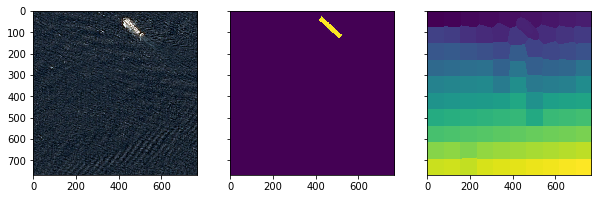

In [199]:
gt = gts[0]
fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(imgs[0])
ax[1].imshow(gts[0])
ax[2].imshow(SLIC_list[0,:])
plt.show()

In [203]:
num = np.sum(gt[SLIC_list[0] == 9] > 125)
denom = gt[SLIC_list[0] == 9].size
print(float(num)/float(denom))
size_true = np.sum(gt > 125)
print(num/size_true)

0.22990543735224586
0.2729824561403509


In [127]:
#
# DEBUG
#
# checking
print(y_train.shape, np.nonzero(y_train[5,:]>0))

(10, 100) (array([], dtype=int64),)


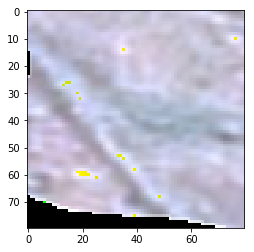

In [143]:
#
# DEBUG
#
# checking
plt.imshow(x_train[9,10,:])
#plt.imshow(xpatchify(imgs[9,:], SLIC[9,:], boxes[9,78,:], 78))#x_train[5,78,:])
plt.show()

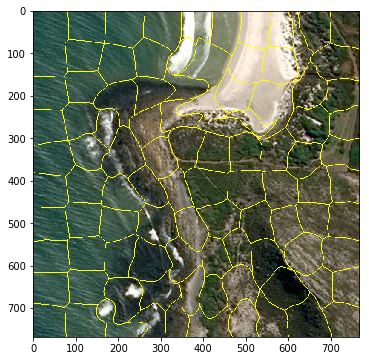

In [139]:
#
# DEBUG
#
# checking
i = 9
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(imgs[i,:], SLIC[i,:]))
plt.show()

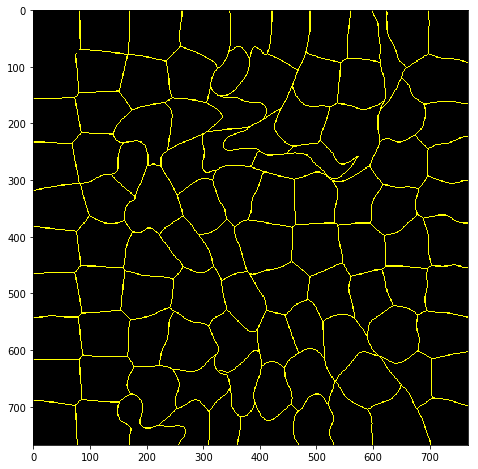

In [141]:
#
# DEBUG
#
# checking
plt.figure(figsize=(8,8))
plt.imshow(mark_boundaries(gts[i,:], SLIC[i,:]))
plt.show()